# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Doga Tekin"
student2 = "Serif Soner Serbest"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [82]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

Answer to question 2:

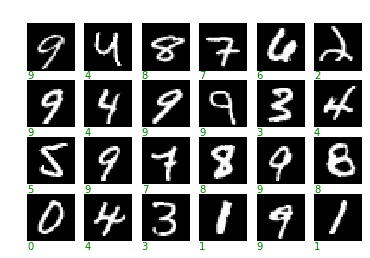

In [83]:
plot_some_samples(x_train, y_train);

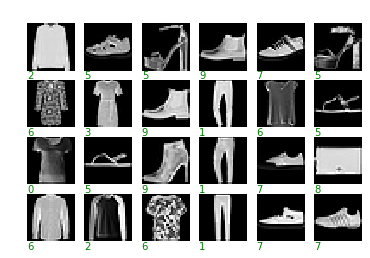

In [84]:
plot_some_samples(x_fashion_train, y_fashion_train);

The green digits indicate the mapped versions of the correct labels of each image by adding one and taking modulo 10.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [85]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [86]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

#### MNIST

In [130]:
model = Sequential([
    Dense(10, input_shape=(784,)),
    Activation('softmax')
])

In [131]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [132]:
# TODO: run for more iterations (until validation loss really stops decreasing)
history = model.fit(x_train, y_train, batch_size=128, epochs=1000, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
60000/60000 [==============================] - 3s 52us/step - loss: 1.2899 - acc: 0.7032 - val_loss: 0.8134 - val_acc: 0.8378
Epoch 2/1000
60000/60000 [==============================] - 1s 17us/step - loss: 0.7141 - acc: 0.8446 - val_loss: 0.6085 - val_acc: 0.8630
Epoch 3/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.5854 - acc: 0.8601 - val_loss: 0.5266 - val_acc: 0.8755
Epoch 4/1000
60000/60000 [==============================] - 1s 21us/step - loss: 0.5240 - acc: 0.8695 - val_loss: 0.4810 - val_acc: 0.8843
Epoch 5/1000
60000/60000 [==============================] - 1s 17us/step - loss: 0.4867 - acc: 0.8759 - val_loss: 0.4510 - val_acc: 0.8870
Epoch 6/1000
60000/60000 [==============================] - 1s 14us/step - loss: 0.4610 - acc: 0.8801 - val_loss: 0.4299 - val_acc: 0.8895
Epoch 7/1000
60000/60000 [==============================] - 2s 28us/step - loss: 0.4419 - acc: 0.8837 - val_loss: 0.

60000/60000 [==============================] - 1s 24us/step - loss: 0.3033 - acc: 0.9157 - val_loss: 0.2944 - val_acc: 0.9183
Epoch 60/1000
60000/60000 [==============================] - 1s 24us/step - loss: 0.3026 - acc: 0.9158 - val_loss: 0.2940 - val_acc: 0.9180
Epoch 61/1000
60000/60000 [==============================] - 1s 21us/step - loss: 0.3021 - acc: 0.9159 - val_loss: 0.2935 - val_acc: 0.9184
Epoch 62/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.3015 - acc: 0.9158 - val_loss: 0.2935 - val_acc: 0.9185
Epoch 63/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.3009 - acc: 0.9162 - val_loss: 0.2928 - val_acc: 0.9184
Epoch 64/1000
60000/60000 [==============================] - 1s 15us/step - loss: 0.3004 - acc: 0.9164 - val_loss: 0.2922 - val_acc: 0.9188
Epoch 65/1000
60000/60000 [==============================] - 1s 14us/step - loss: 0.2999 - acc: 0.9165 - val_loss: 0.2919 - val_acc: 0.9187
Epoch 66/1000
60000/60000 [=======

60000/60000 [==============================] - 1s 20us/step - loss: 0.2824 - acc: 0.9215 - val_loss: 0.2799 - val_acc: 0.9210
Epoch 118/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2822 - acc: 0.9214 - val_loss: 0.2797 - val_acc: 0.9214
Epoch 119/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2820 - acc: 0.9217 - val_loss: 0.2796 - val_acc: 0.9212
Epoch 120/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2817 - acc: 0.9215 - val_loss: 0.2794 - val_acc: 0.9212
Epoch 121/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2815 - acc: 0.9215 - val_loss: 0.2794 - val_acc: 0.9214
Epoch 122/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2813 - acc: 0.9218 - val_loss: 0.2793 - val_acc: 0.9209
Epoch 123/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2811 - acc: 0.9218 - val_loss: 0.2790 - val_acc: 0.9214
Epoch 124/1000
60000/60000 [

60000/60000 [==============================] - 1s 18us/step - loss: 0.2726 - acc: 0.9243 - val_loss: 0.2746 - val_acc: 0.9221
Epoch 176/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2725 - acc: 0.9244 - val_loss: 0.2742 - val_acc: 0.9220
Epoch 177/1000
60000/60000 [==============================] - 1s 17us/step - loss: 0.2724 - acc: 0.9244 - val_loss: 0.2739 - val_acc: 0.9219
Epoch 178/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2723 - acc: 0.9244 - val_loss: 0.2738 - val_acc: 0.9224
Epoch 179/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2721 - acc: 0.9247 - val_loss: 0.2739 - val_acc: 0.9221
Epoch 180/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2720 - acc: 0.9246 - val_loss: 0.2737 - val_acc: 0.9219
Epoch 181/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2719 - acc: 0.9245 - val_loss: 0.2739 - val_acc: 0.9221
Epoch 182/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2666 - acc: 0.9259 - val_loss: 0.2710 - val_acc: 0.9228
Epoch 234/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2665 - acc: 0.9263 - val_loss: 0.2709 - val_acc: 0.9227
Epoch 235/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2664 - acc: 0.9265 - val_loss: 0.2710 - val_acc: 0.9226
Epoch 236/1000
60000/60000 [==============================] - 1s 22us/step - loss: 0.2664 - acc: 0.9262 - val_loss: 0.2710 - val_acc: 0.9229
Epoch 237/1000
60000/60000 [==============================] - 1s 17us/step - loss: 0.2663 - acc: 0.9265 - val_loss: 0.2709 - val_acc: 0.9224
Epoch 238/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2662 - acc: 0.9265 - val_loss: 0.2710 - val_acc: 0.9231
Epoch 239/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2661 - acc: 0.9264 - val_loss: 0.2709 - val_acc: 0.9226
Epoch 240/1000
60000/60000 [

60000/60000 [==============================] - 1s 18us/step - loss: 0.2623 - acc: 0.9277 - val_loss: 0.2692 - val_acc: 0.9228
Epoch 292/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2622 - acc: 0.9280 - val_loss: 0.2691 - val_acc: 0.9227
Epoch 293/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2622 - acc: 0.9280 - val_loss: 0.2692 - val_acc: 0.9231
Epoch 294/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2621 - acc: 0.9277 - val_loss: 0.2691 - val_acc: 0.9231
Epoch 295/1000
60000/60000 [==============================] - 1s 17us/step - loss: 0.2620 - acc: 0.9278 - val_loss: 0.2691 - val_acc: 0.9228
Epoch 296/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2620 - acc: 0.9278 - val_loss: 0.2691 - val_acc: 0.9236
Epoch 297/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2619 - acc: 0.9282 - val_loss: 0.2691 - val_acc: 0.9224
Epoch 298/1000
60000/60000 [

60000/60000 [==============================] - 1s 20us/step - loss: 0.2590 - acc: 0.9288 - val_loss: 0.2679 - val_acc: 0.9241
Epoch 350/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2589 - acc: 0.9288 - val_loss: 0.2679 - val_acc: 0.9242
Epoch 351/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2588 - acc: 0.9290 - val_loss: 0.2681 - val_acc: 0.9236
Epoch 352/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2588 - acc: 0.9287 - val_loss: 0.2678 - val_acc: 0.9239
Epoch 353/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2587 - acc: 0.9291 - val_loss: 0.2677 - val_acc: 0.9243
Epoch 354/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2587 - acc: 0.9291 - val_loss: 0.2677 - val_acc: 0.9237
Epoch 355/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2587 - acc: 0.9289 - val_loss: 0.2676 - val_acc: 0.9240
Epoch 356/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2563 - acc: 0.9296 - val_loss: 0.2670 - val_acc: 0.9237
Epoch 408/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2563 - acc: 0.9296 - val_loss: 0.2670 - val_acc: 0.9239
Epoch 409/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2562 - acc: 0.9297 - val_loss: 0.2670 - val_acc: 0.9238
Epoch 410/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2562 - acc: 0.9295 - val_loss: 0.2670 - val_acc: 0.9236
Epoch 411/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2561 - acc: 0.9294 - val_loss: 0.2670 - val_acc: 0.9242
Epoch 412/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2561 - acc: 0.9295 - val_loss: 0.2669 - val_acc: 0.9239
Epoch 413/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2561 - acc: 0.9298 - val_loss: 0.2670 - val_acc: 0.9240
Epoch 414/1000
60000/60000 [

60000/60000 [==============================] - 1s 18us/step - loss: 0.2541 - acc: 0.9302 - val_loss: 0.2662 - val_acc: 0.9245
Epoch 466/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2540 - acc: 0.9302 - val_loss: 0.2662 - val_acc: 0.9241
Epoch 467/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2540 - acc: 0.9300 - val_loss: 0.2662 - val_acc: 0.9244
Epoch 468/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2540 - acc: 0.9303 - val_loss: 0.2664 - val_acc: 0.9239
Epoch 469/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2540 - acc: 0.9304 - val_loss: 0.2662 - val_acc: 0.9242
Epoch 470/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2539 - acc: 0.9301 - val_loss: 0.2663 - val_acc: 0.9242
Epoch 471/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2539 - acc: 0.9302 - val_loss: 0.2662 - val_acc: 0.9244
Epoch 472/1000
60000/60000 [

Epoch 523/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2522 - acc: 0.9309 - val_loss: 0.2656 - val_acc: 0.9252
Epoch 524/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2522 - acc: 0.9310 - val_loss: 0.2657 - val_acc: 0.9249
Epoch 525/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2521 - acc: 0.9308 - val_loss: 0.2657 - val_acc: 0.9251
Epoch 526/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2521 - acc: 0.9308 - val_loss: 0.2656 - val_acc: 0.9249
Epoch 527/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2521 - acc: 0.9307 - val_loss: 0.2658 - val_acc: 0.9253
Epoch 528/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2520 - acc: 0.9310 - val_loss: 0.2658 - val_acc: 0.9247
Epoch 529/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2520 - acc: 0.9308 - val_loss: 0.2655 - val_acc: 0.9252
Epoch 530/100

60000/60000 [==============================] - 1s 18us/step - loss: 0.2505 - acc: 0.9312 - val_loss: 0.2653 - val_acc: 0.9250
Epoch 582/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2505 - acc: 0.9313 - val_loss: 0.2654 - val_acc: 0.9252
Epoch 583/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2504 - acc: 0.9314 - val_loss: 0.2657 - val_acc: 0.9249
Epoch 584/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2505 - acc: 0.9314 - val_loss: 0.2653 - val_acc: 0.9250
Epoch 585/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2504 - acc: 0.9311 - val_loss: 0.2651 - val_acc: 0.9256
Epoch 586/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2504 - acc: 0.9314 - val_loss: 0.2655 - val_acc: 0.9251
Epoch 587/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2503 - acc: 0.9311 - val_loss: 0.2656 - val_acc: 0.9250
Epoch 588/1000
60000/60000 [

60000/60000 [==============================] - 1s 18us/step - loss: 0.2491 - acc: 0.9317 - val_loss: 0.2650 - val_acc: 0.9252
Epoch 640/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2491 - acc: 0.9314 - val_loss: 0.2652 - val_acc: 0.9246
Epoch 641/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2490 - acc: 0.9316 - val_loss: 0.2649 - val_acc: 0.9250
Epoch 642/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2490 - acc: 0.9315 - val_loss: 0.2650 - val_acc: 0.9251
Epoch 643/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2490 - acc: 0.9316 - val_loss: 0.2650 - val_acc: 0.9251
Epoch 644/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2489 - acc: 0.9316 - val_loss: 0.2654 - val_acc: 0.9247
Epoch 645/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2490 - acc: 0.9316 - val_loss: 0.2651 - val_acc: 0.9249
Epoch 646/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2477 - acc: 0.9319 - val_loss: 0.2650 - val_acc: 0.9252
Epoch 698/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2477 - acc: 0.9318 - val_loss: 0.2647 - val_acc: 0.9253
Epoch 699/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2478 - acc: 0.9317 - val_loss: 0.2648 - val_acc: 0.9250
Epoch 700/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2477 - acc: 0.9320 - val_loss: 0.2648 - val_acc: 0.9252
Epoch 701/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2477 - acc: 0.9319 - val_loss: 0.2650 - val_acc: 0.9252
Epoch 702/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2477 - acc: 0.9320 - val_loss: 0.2649 - val_acc: 0.9254
Epoch 703/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2477 - acc: 0.9318 - val_loss: 0.2648 - val_acc: 0.9253
Epoch 704/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2466 - acc: 0.9320 - val_loss: 0.2647 - val_acc: 0.9254
Epoch 756/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2466 - acc: 0.9323 - val_loss: 0.2646 - val_acc: 0.9254
Epoch 757/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2466 - acc: 0.9321 - val_loss: 0.2647 - val_acc: 0.9255
Epoch 758/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2466 - acc: 0.9319 - val_loss: 0.2646 - val_acc: 0.9252
Epoch 759/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2466 - acc: 0.9323 - val_loss: 0.2646 - val_acc: 0.9255
Epoch 760/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2465 - acc: 0.9323 - val_loss: 0.2645 - val_acc: 0.9254
Epoch 761/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2465 - acc: 0.9322 - val_loss: 0.2646 - val_acc: 0.9256
Epoch 762/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2456 - acc: 0.9326 - val_loss: 0.2647 - val_acc: 0.9254
Epoch 814/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2456 - acc: 0.9327 - val_loss: 0.2646 - val_acc: 0.9256
Epoch 815/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2455 - acc: 0.9324 - val_loss: 0.2645 - val_acc: 0.9251
Epoch 816/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2455 - acc: 0.9324 - val_loss: 0.2646 - val_acc: 0.9253
Epoch 817/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2455 - acc: 0.9325 - val_loss: 0.2646 - val_acc: 0.9255
Epoch 818/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2455 - acc: 0.9325 - val_loss: 0.2644 - val_acc: 0.9257
Epoch 819/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2455 - acc: 0.9325 - val_loss: 0.2645 - val_acc: 0.9256
Epoch 820/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2446 - acc: 0.9326 - val_loss: 0.2643 - val_acc: 0.9262
Epoch 872/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2446 - acc: 0.9327 - val_loss: 0.2643 - val_acc: 0.9255
Epoch 873/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2446 - acc: 0.9331 - val_loss: 0.2643 - val_acc: 0.9258
Epoch 874/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2446 - acc: 0.9328 - val_loss: 0.2643 - val_acc: 0.9258
Epoch 875/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2445 - acc: 0.9328 - val_loss: 0.2644 - val_acc: 0.9257
Epoch 876/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2445 - acc: 0.9326 - val_loss: 0.2644 - val_acc: 0.9256
Epoch 877/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2445 - acc: 0.9328 - val_loss: 0.2643 - val_acc: 0.9257
Epoch 878/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2437 - acc: 0.9331 - val_loss: 0.2646 - val_acc: 0.9251
Epoch 930/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2437 - acc: 0.9330 - val_loss: 0.2644 - val_acc: 0.9258
Epoch 931/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2437 - acc: 0.9332 - val_loss: 0.2644 - val_acc: 0.9256
Epoch 932/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2436 - acc: 0.9332 - val_loss: 0.2645 - val_acc: 0.9254
Epoch 933/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2436 - acc: 0.9332 - val_loss: 0.2643 - val_acc: 0.9257
Epoch 934/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2436 - acc: 0.9331 - val_loss: 0.2643 - val_acc: 0.9260
Epoch 935/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2436 - acc: 0.9331 - val_loss: 0.2642 - val_acc: 0.9257
Epoch 936/1000
60000/60000 [

60000/60000 [==============================] - 1s 19us/step - loss: 0.2429 - acc: 0.9333 - val_loss: 0.2645 - val_acc: 0.9258
Epoch 988/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2429 - acc: 0.9331 - val_loss: 0.2644 - val_acc: 0.9254
Epoch 989/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2428 - acc: 0.9334 - val_loss: 0.2642 - val_acc: 0.9255
Epoch 990/1000
60000/60000 [==============================] - 1s 20us/step - loss: 0.2428 - acc: 0.9334 - val_loss: 0.2643 - val_acc: 0.9254
Epoch 991/1000
60000/60000 [==============================] - 1s 18us/step - loss: 0.2428 - acc: 0.9334 - val_loss: 0.2643 - val_acc: 0.9257
Epoch 992/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2428 - acc: 0.9334 - val_loss: 0.2645 - val_acc: 0.9254
Epoch 993/1000
60000/60000 [==============================] - 1s 19us/step - loss: 0.2428 - acc: 0.9333 - val_loss: 0.2642 - val_acc: 0.9262
Epoch 994/1000
60000/60000 [

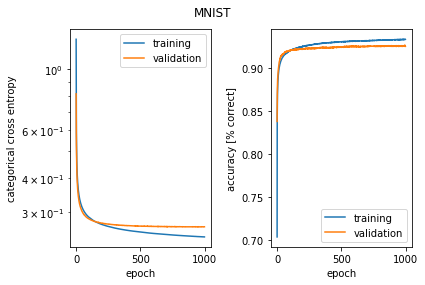

In [133]:
plot_history(history, 'MNIST');

In [134]:
yhat_test = model.predict_classes(x_test)
labels = y_test.argmax(axis=1)

error_indices = np.where(yhat_test != labels)[0]

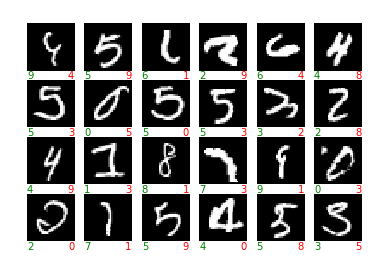

In [135]:
plot_some_samples(x_test, labels, yhat_test, error_indices);

The green digits are the true classes of the digits and the red digits are the predictions of our network.

#### Fashion-MNIST

In [75]:
model = Sequential([
    Dense(10, input_shape=(784,)),
    Activation('softmax')
])

In [76]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=500, 
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 10us/step - loss: 1.1606 - acc: 0.6437 - val_loss: 0.8729 - val_acc: 0.7090
Epoch 2/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.7823 - acc: 0.7490 - val_loss: 0.7472 - val_acc: 0.7505
Epoch 3/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.6959 - acc: 0.7781 - val_loss: 0.6889 - val_acc: 0.7697
Epoch 4/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.6490 - acc: 0.7930 - val_loss: 0.6525 - val_acc: 0.7830
Epoch 5/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.6180 - acc: 0.8023 - val_loss: 0.6281 - val_acc: 0.7910
Epoch 6/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.5954 - acc: 0.8079 - val_loss: 0.6095 - val_acc: 0.7970
Epoch 7/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.5779 - acc: 0.8130 - val_loss: 0.5947 - val_a

Epoch 60/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4338 - acc: 0.8531 - val_loss: 0.4698 - val_acc: 0.8367
Epoch 61/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4331 - acc: 0.8539 - val_loss: 0.4694 - val_acc: 0.8377
Epoch 62/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4323 - acc: 0.8542 - val_loss: 0.4709 - val_acc: 0.8360
Epoch 63/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4317 - acc: 0.8543 - val_loss: 0.4684 - val_acc: 0.8377
Epoch 64/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4311 - acc: 0.8547 - val_loss: 0.4691 - val_acc: 0.8364
Epoch 65/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4306 - acc: 0.8541 - val_loss: 0.4690 - val_acc: 0.8365
Epoch 66/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4301 - acc: 0.8546 - val_loss: 0.4674 - val_acc: 0.8383
Epoch 67/500
60000/60000 [========

60000/60000 [==============================] - 1s 10us/step - loss: 0.4098 - acc: 0.8606 - val_loss: 0.4519 - val_acc: 0.8427
Epoch 120/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4096 - acc: 0.8608 - val_loss: 0.4519 - val_acc: 0.8419
Epoch 121/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4094 - acc: 0.8611 - val_loss: 0.4521 - val_acc: 0.8417
Epoch 122/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4090 - acc: 0.8608 - val_loss: 0.4512 - val_acc: 0.8424
Epoch 123/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4089 - acc: 0.8607 - val_loss: 0.4512 - val_acc: 0.8419
Epoch 124/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4086 - acc: 0.8615 - val_loss: 0.4507 - val_acc: 0.8427
Epoch 125/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4083 - acc: 0.8607 - val_loss: 0.4510 - val_acc: 0.8417
Epoch 126/500
60000/60000 [=============

Epoch 178/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3985 - acc: 0.8642 - val_loss: 0.4446 - val_acc: 0.8443
Epoch 179/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.3983 - acc: 0.8638 - val_loss: 0.4449 - val_acc: 0.8442
Epoch 180/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3982 - acc: 0.8646 - val_loss: 0.4448 - val_acc: 0.8423
Epoch 181/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3981 - acc: 0.8638 - val_loss: 0.4442 - val_acc: 0.8437
Epoch 182/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3979 - acc: 0.8637 - val_loss: 0.4447 - val_acc: 0.8433
Epoch 183/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3977 - acc: 0.8644 - val_loss: 0.4448 - val_acc: 0.8427
Epoch 184/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3974 - acc: 0.8639 - val_loss: 0.4450 - val_acc: 0.8434
Epoch 185/500
60000/60000

60000/60000 [==============================] - 1s 10us/step - loss: 0.3863 - acc: 0.8674 - val_loss: 0.4379 - val_acc: 0.8459
Epoch 295/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3862 - acc: 0.8672 - val_loss: 0.4380 - val_acc: 0.8449
Epoch 296/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3861 - acc: 0.8673 - val_loss: 0.4390 - val_acc: 0.8436
Epoch 297/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3860 - acc: 0.8671 - val_loss: 0.4385 - val_acc: 0.8450
Epoch 298/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3859 - acc: 0.8676 - val_loss: 0.4394 - val_acc: 0.8442
Epoch 299/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3858 - acc: 0.8678 - val_loss: 0.4382 - val_acc: 0.8450
Epoch 300/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3858 - acc: 0.8669 - val_loss: 0.4378 - val_acc: 0.8444
Epoch 301/500
60000/60000 [==========

Epoch 353/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3822 - acc: 0.8685 - val_loss: 0.4365 - val_acc: 0.8450
Epoch 354/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3822 - acc: 0.8688 - val_loss: 0.4366 - val_acc: 0.8453
Epoch 355/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3820 - acc: 0.8688 - val_loss: 0.4365 - val_acc: 0.8450
Epoch 356/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3821 - acc: 0.8685 - val_loss: 0.4367 - val_acc: 0.8437
Epoch 357/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3819 - acc: 0.8686 - val_loss: 0.4363 - val_acc: 0.8450
Epoch 358/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3819 - acc: 0.8686 - val_loss: 0.4367 - val_acc: 0.8451
Epoch 359/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3818 - acc: 0.8685 - val_loss: 0.4363 - val_acc: 0.8458
Epoch 360/500
60000/60000 

Epoch 412/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3790 - acc: 0.8691 - val_loss: 0.4366 - val_acc: 0.8453
Epoch 413/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3789 - acc: 0.8690 - val_loss: 0.4353 - val_acc: 0.8453
Epoch 414/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3787 - acc: 0.8691 - val_loss: 0.4368 - val_acc: 0.8452
Epoch 415/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3788 - acc: 0.8698 - val_loss: 0.4355 - val_acc: 0.8452
Epoch 416/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3788 - acc: 0.8697 - val_loss: 0.4355 - val_acc: 0.8448
Epoch 417/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3785 - acc: 0.8693 - val_loss: 0.4375 - val_acc: 0.8452
Epoch 418/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3785 - acc: 0.8698 - val_loss: 0.4357 - val_acc: 0.8453
Epoch 419/500
60000/6000

Epoch 471/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3763 - acc: 0.8701 - val_loss: 0.4360 - val_acc: 0.8447
Epoch 472/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3763 - acc: 0.8702 - val_loss: 0.4351 - val_acc: 0.8462
Epoch 473/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3762 - acc: 0.8701 - val_loss: 0.4349 - val_acc: 0.8456
Epoch 474/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3762 - acc: 0.8698 - val_loss: 0.4347 - val_acc: 0.8455
Epoch 475/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3761 - acc: 0.8703 - val_loss: 0.4351 - val_acc: 0.8454
Epoch 476/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3760 - acc: 0.8705 - val_loss: 0.4347 - val_acc: 0.8455
Epoch 477/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3760 - acc: 0.8698 - val_loss: 0.4360 - val_acc: 0.8434
Epoch 478/500
60000/60000 [

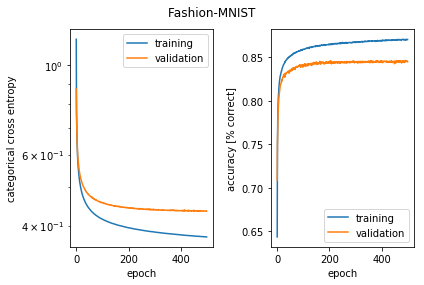

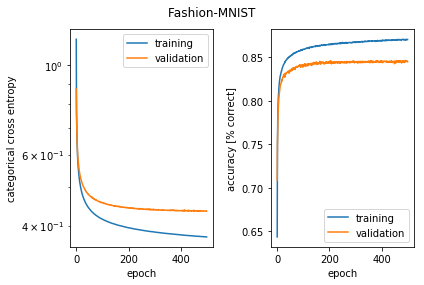

In [78]:
plot_history(history, 'Fashion-MNIST');

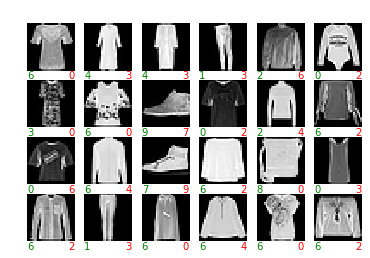

In [81]:
yhat_fashion_test = model.predict_classes(x_fashion_test)
labels = y_fashion_test.argmax(axis=1)

error_indices = np.where(yhat_fashion_test != labels)[0]

plot_some_samples(x_fashion_test, labels, yhat_fashion_test, error_indices);

The green digits are the true classes of the fashion items and the red digits are the predictions of our network.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [30]:
def train_model(x_train, y_train, x_test, y_test, optimizer, learning_rates, epoch=50):
    histories = []
    
    for lr in learning_rates:
        model = Sequential([
            Dense(128, input_shape=(784,)),
            Activation('relu'),
            Dense(10),
            Activation('softmax')
        ])

        model.compile(optimizer=optimizer(lr=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        histories.append(model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)))
        
    return histories

In [17]:
learning_rates = [10**-i for i in range(5)] 
sgd_histories = []

for lr in learning_rates:
    model = Sequential([
        Dense(128, input_shape=(784,)),
        Activation('relu'),
        Dense(10),
        Activation('softmax')
    ])
    
    sgd = SGD(lr=lr)

    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    sgd_histories.append(model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.3473 - acc: 0.8929 - val_loss: 0.1357 - val_acc: 0.9578
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.1282 - acc: 0.9613 - val_loss: 0.1154 - val_acc: 0.9650
Epoch 3/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.0914 - acc: 0.9728 - val_loss: 0.0991 - val_acc: 0.9701
Epoch 4/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0760 - acc: 0.9762 - val_loss: 0.1015 - val_acc: 0.9693
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0630 - acc: 0.9798 - val_loss: 0.0896 - val_acc: 0.9728
Epoch 6/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.0543 - acc: 0.9827 - val_loss: 0.0920 - val_acc: 0.9722
Epoch 7/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.0463 - acc: 0.9856 - val_loss: 0.0909 - val_acc

60000/60000 [==============================] - 1s 13us/step - loss: 0.2333 - acc: 0.9340 - val_loss: 0.2266 - val_acc: 0.9363
Epoch 19/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2282 - acc: 0.9354 - val_loss: 0.2225 - val_acc: 0.9378
Epoch 20/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2233 - acc: 0.9371 - val_loss: 0.2183 - val_acc: 0.9400
Epoch 21/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2187 - acc: 0.9382 - val_loss: 0.2141 - val_acc: 0.9409
Epoch 22/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2142 - acc: 0.9400 - val_loss: 0.2095 - val_acc: 0.9416
Epoch 23/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.2098 - acc: 0.9411 - val_loss: 0.2070 - val_acc: 0.9421
Epoch 24/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2059 - acc: 0.9423 - val_loss: 0.2032 - val_acc: 0.9425
Epoch 25/50
60000/60000 [=====================

60000/60000 [==============================] - 1s 13us/step - loss: 1.2917 - acc: 0.7199 - val_loss: 1.2644 - val_acc: 0.7291
Epoch 37/50
60000/60000 [==============================] - 1s 12us/step - loss: 1.2719 - acc: 0.7237 - val_loss: 1.2447 - val_acc: 0.7322
Epoch 38/50
60000/60000 [==============================] - 1s 13us/step - loss: 1.2526 - acc: 0.7278 - val_loss: 1.2255 - val_acc: 0.7372
Epoch 39/50
60000/60000 [==============================] - 1s 15us/step - loss: 1.2339 - acc: 0.7311 - val_loss: 1.2068 - val_acc: 0.7412
Epoch 40/50
60000/60000 [==============================] - 1s 14us/step - loss: 1.2158 - acc: 0.7352 - val_loss: 1.1887 - val_acc: 0.7461
Epoch 41/50
60000/60000 [==============================] - 1s 15us/step - loss: 1.1981 - acc: 0.7393 - val_loss: 1.1711 - val_acc: 0.7500
Epoch 42/50
60000/60000 [==============================] - 1s 13us/step - loss: 1.1810 - acc: 0.7426 - val_loss: 1.1540 - val_acc: 0.7536
Epoch 43/50
60000/60000 [=====================

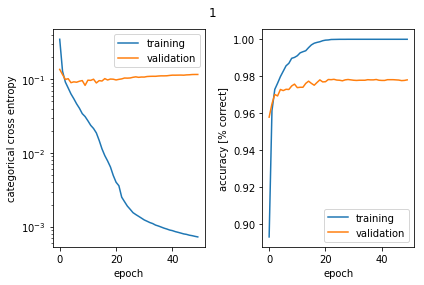

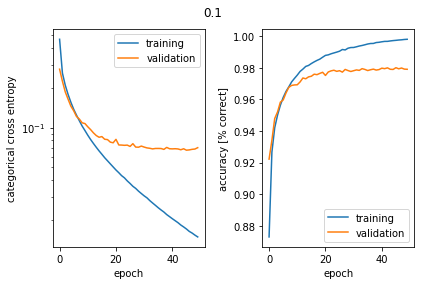

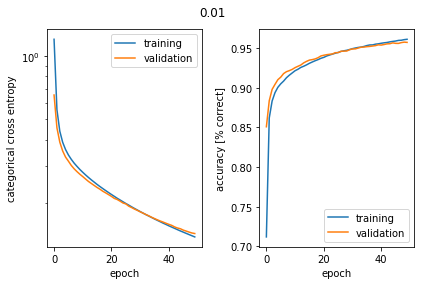

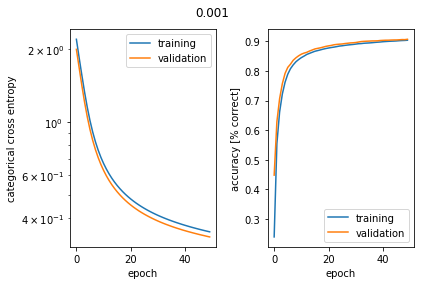

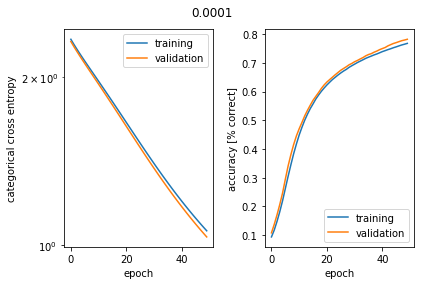

In [18]:
for history, lr in zip(sgd_histories, learning_rates):
    plot_history(history, lr)

In [21]:
learning_rates = [10**-i for i in range(5)] 
adam_histories = []

for lr in learning_rates:
    model = Sequential([
        Dense(128, input_shape=(784,)),
        Activation('relu'),
        Dense(10),
        Activation('softmax')
    ])
    
    sgd = Adam(lr=lr)

    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    adam_histories.append(model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/step - loss: 14.5038 - acc: 0.0985 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 2/50
60000/60000 [==============================] - 1s 17us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 5/50
60000/60000 [==============================] - 1s 16us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 7/50
60000/60000 [==============================] - 1s 18us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.

60000/60000 [==============================] - 1s 16us/step - loss: 6.6131 - acc: 0.5896 - val_loss: 6.6930 - val_acc: 0.5845
Epoch 10/50
60000/60000 [==============================] - 1s 17us/step - loss: 6.3487 - acc: 0.6058 - val_loss: 6.6741 - val_acc: 0.5855
Epoch 11/50
60000/60000 [==============================] - 1s 15us/step - loss: 5.7970 - acc: 0.6400 - val_loss: 4.9466 - val_acc: 0.6930
Epoch 12/50
60000/60000 [==============================] - 1s 16us/step - loss: 5.5435 - acc: 0.6558 - val_loss: 5.8202 - val_acc: 0.6386
Epoch 13/50
60000/60000 [==============================] - 1s 17us/step - loss: 5.5819 - acc: 0.6535 - val_loss: 5.5625 - val_acc: 0.6546
Epoch 14/50
60000/60000 [==============================] - 1s 17us/step - loss: 5.2662 - acc: 0.6731 - val_loss: 4.7689 - val_acc: 0.7040
Epoch 15/50
60000/60000 [==============================] - 1s 18us/step - loss: 5.2344 - acc: 0.6751 - val_loss: 4.8421 - val_acc: 0.6994
Epoch 16/50
60000/60000 [=====================

60000/60000 [==============================] - 1s 24us/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0856 - val_acc: 0.9795
Epoch 28/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0832 - val_acc: 0.9796
Epoch 29/50
60000/60000 [==============================] - 1s 18us/step - loss: 8.9249e-04 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9795
Epoch 30/50
60000/60000 [==============================] - 1s 18us/step - loss: 7.7231e-04 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9807
Epoch 31/50
60000/60000 [==============================] - 1s 19us/step - loss: 7.2616e-04 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9797
Epoch 32/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.1150 - val_acc: 0.9736
Epoch 33/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.0077 - acc: 0.9973 - val_loss: 0.0933 - val_acc: 0.9771
Epoch 34/50
60000/60000 [=========

Epoch 36/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0651 - acc: 0.9826 - val_loss: 0.0907 - val_acc: 0.9725
Epoch 37/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0632 - acc: 0.9832 - val_loss: 0.0890 - val_acc: 0.9732
Epoch 38/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0612 - acc: 0.9836 - val_loss: 0.0871 - val_acc: 0.9727
Epoch 39/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0594 - acc: 0.9841 - val_loss: 0.0865 - val_acc: 0.9729
Epoch 40/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0577 - acc: 0.9848 - val_loss: 0.0856 - val_acc: 0.9742
Epoch 41/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0560 - acc: 0.9854 - val_loss: 0.0852 - val_acc: 0.9744
Epoch 42/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0545 - acc: 0.9861 - val_loss: 0.0841 - val_acc: 0.9749
Epoch 43/50
60000/60000 [=========

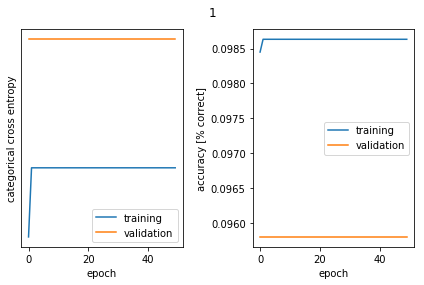

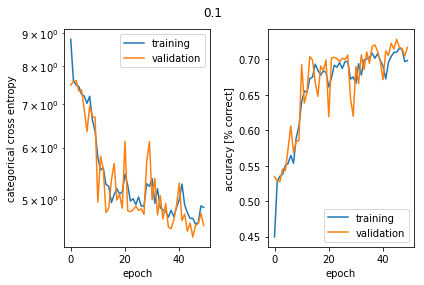

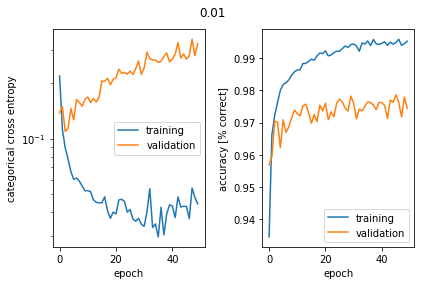

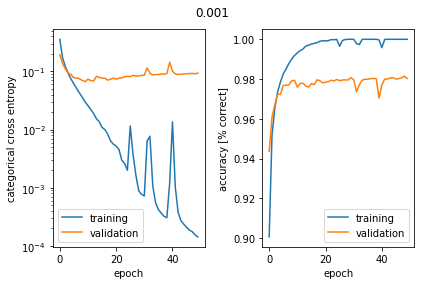

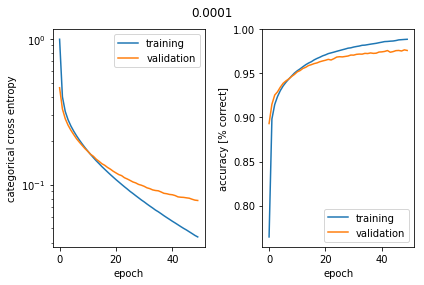

In [22]:
for history, lr in zip(adam_histories, learning_rates):
    plot_history(history, lr)

In [41]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

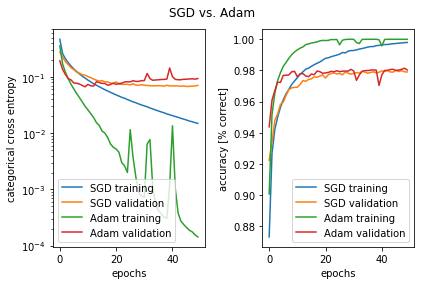

In [29]:
comparison_plot(sgd_histories[1], adam_histories[3], 'SGD', 'Adam', 'SGD vs. Adam');

In [32]:
fashion_histories = train_model(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, Adam, [0.0001, 0.001, 0.01])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.9452 - acc: 0.7036 - val_loss: 0.6508 - val_acc: 0.7840
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.5690 - acc: 0.8138 - val_loss: 0.5515 - val_acc: 0.8160
Epoch 3/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.5004 - acc: 0.8325 - val_loss: 0.5072 - val_acc: 0.8298
Epoch 4/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4651 - acc: 0.8429 - val_loss: 0.4797 - val_acc: 0.8365
Epoch 5/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4415 - acc: 0.8501 - val_loss: 0.4608 - val_acc: 0.8420
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.4232 - acc: 0.8561 - val_loss: 0.4507 - val_acc: 0.8432
Epoch 7/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4092 - acc: 0.8593 - val_loss: 0.4384 - val_acc

Epoch 10/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2645 - acc: 0.9032 - val_loss: 0.3398 - val_acc: 0.8760
Epoch 11/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2577 - acc: 0.9062 - val_loss: 0.3412 - val_acc: 0.8774
Epoch 12/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.2493 - acc: 0.9084 - val_loss: 0.3336 - val_acc: 0.8817
Epoch 13/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2438 - acc: 0.9107 - val_loss: 0.3294 - val_acc: 0.8814
Epoch 14/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.2324 - acc: 0.9154 - val_loss: 0.3291 - val_acc: 0.8851
Epoch 15/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2281 - acc: 0.9159 - val_loss: 0.3349 - val_acc: 0.8816
Epoch 16/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2226 - acc: 0.9184 - val_loss: 0.3344 - val_acc: 0.8841
Epoch 17/50
60000/60000 [=========

60000/60000 [==============================] - 1s 19us/step - loss: 0.2723 - acc: 0.8989 - val_loss: 0.4114 - val_acc: 0.8627
Epoch 20/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2676 - acc: 0.9010 - val_loss: 0.3923 - val_acc: 0.8707
Epoch 21/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2595 - acc: 0.9034 - val_loss: 0.4334 - val_acc: 0.8660
Epoch 22/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2601 - acc: 0.9027 - val_loss: 0.4233 - val_acc: 0.8671
Epoch 23/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2596 - acc: 0.9034 - val_loss: 0.4002 - val_acc: 0.8697
Epoch 24/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2613 - acc: 0.9046 - val_loss: 0.4176 - val_acc: 0.8713
Epoch 25/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2508 - acc: 0.9074 - val_loss: 0.4466 - val_acc: 0.8566
Epoch 26/50
60000/60000 [=====================

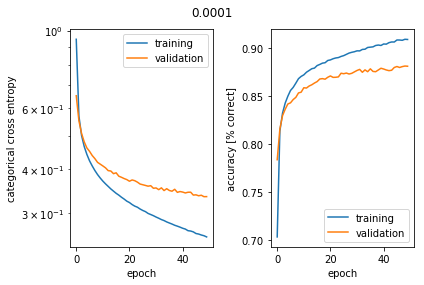

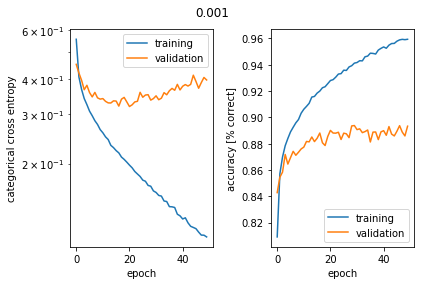

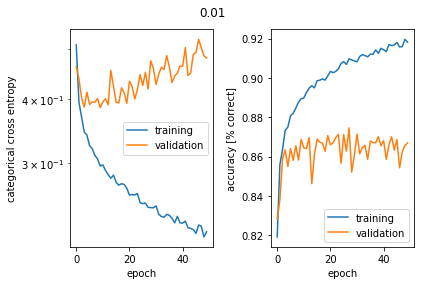

In [38]:
for history, lr in zip(fashion_histories, [0.0001, 0.001, 0.01]):
    plot_history(history, lr)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) The model underfits because the update steps are too large to converge on the minima of the error surface.

B) The model again underfits because the update steps are too small to get close to the minima with a limited number of epochs.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: With the best learning rate for 50 epochs, Adam starts to overfit at epoch 10.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: According to our observations, the accuracy curves can keep increasing even after the loss curve shows clear signs of overfitting. So accuracy curves are less prone to respond to overfitting.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [7]:
from keras.callbacks import EarlyStopping

In [27]:
def train_model(x_train, y_train, x_test, y_test, num_neurons, epochs=50, early_stop=True):
    histories = []
    
    for neurons in num_neurons:
        model = Sequential([
            Dense(neurons, input_shape=(784,)),
            Activation('relu'),
            Dense(10),
            Activation('softmax')
        ])

        model.compile(optimizer=Adam(lr=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        callbacks = []
        
        if early_stop:
            callbacks.append(EarlyStopping(patience=5))
        
        histories.append(model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), 
                                   callbacks=callbacks))
        
    return histories

In [28]:
mnist_histories = train_model(x_train, y_train, x_test, y_test, [10, 250, 500, 750, 1000], epochs=50, early_stop=False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.8114 - acc: 0.7661 - val_loss: 0.3667 - val_acc: 0.9009
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.3393 - acc: 0.9047 - val_loss: 0.2969 - val_acc: 0.9169
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.2964 - acc: 0.9166 - val_loss: 0.2781 - val_acc: 0.9204
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.2784 - acc: 0.9217 - val_loss: 0.2675 - val_acc: 0.9228
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2669 - acc: 0.9251 - val_loss: 0.2590 - val_acc: 0.9257
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.2585 - acc: 0.9273 - val_loss: 0.2561 - val_acc: 0.9272
Epoch 7/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2532 - acc: 0.9294 - val_loss: 0.2550 - val_acc

60000/60000 [==============================] - 2s 39us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0765 - val_acc: 0.9813
Epoch 18/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0691 - val_acc: 0.9831
Epoch 19/50
60000/60000 [==============================] - 2s 39us/step - loss: 6.2852e-04 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9831
Epoch 20/50
60000/60000 [==============================] - 2s 39us/step - loss: 3.0588e-04 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9838
Epoch 21/50
60000/60000 [==============================] - 2s 39us/step - loss: 2.4064e-04 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9833
Epoch 22/50
60000/60000 [==============================] - 2s 39us/step - loss: 1.8892e-04 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 0.9835
Epoch 23/50
60000/60000 [==============================] - 2s 39us/step - loss: 1.6649e-04 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9829
Epoch 24/50
60000/60000 [=

60000/60000 [==============================] - 5s 86us/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0996 - val_acc: 0.9812
Epoch 34/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.0847 - val_acc: 0.9837
Epoch 35/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0999 - val_acc: 0.9802
Epoch 36/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0872 - val_acc: 0.9839
Epoch 37/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0027 - acc: 0.9992 - val_loss: 0.0929 - val_acc: 0.9826
Epoch 38/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0822 - val_acc: 0.9848
Epoch 39/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.1036 - val_acc: 0.9816
Epoch 40/50
60000/60000 [=====================

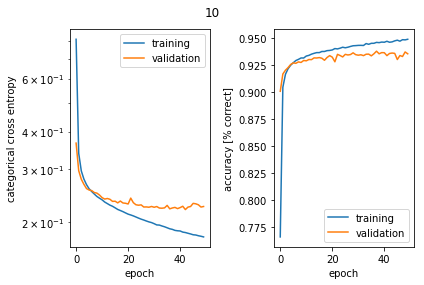

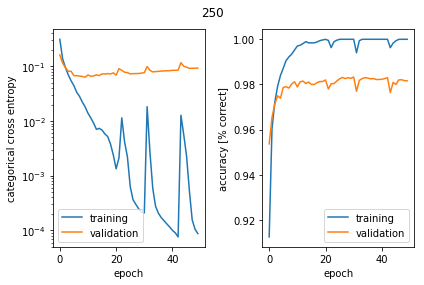

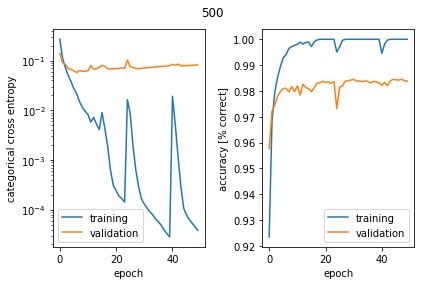

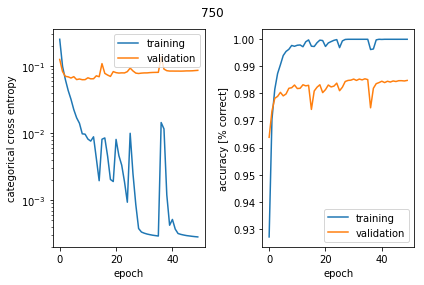

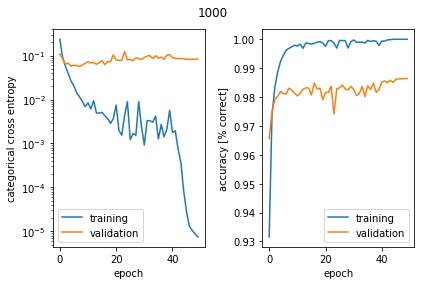

In [29]:
for history, lr in zip(mnist_histories, [10, 250, 500, 750, 1000]):
    plot_history(history, lr)

In [30]:
fashion_mnist_histories = train_model(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 
                              [10, 250, 500, 750, 1000], epochs=50, early_stop=False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.9170 - acc: 0.6987 - val_loss: 0.6048 - val_acc: 0.7913
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.5311 - acc: 0.8197 - val_loss: 0.5297 - val_acc: 0.8161
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.4850 - acc: 0.8343 - val_loss: 0.5002 - val_acc: 0.8280
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.4632 - acc: 0.8405 - val_loss: 0.4900 - val_acc: 0.8291
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.4498 - acc: 0.8451 - val_loss: 0.4749 - val_acc: 0.8326
Epoch 6/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.4356 - acc: 0.8492 - val_loss: 0.4728 - val_acc: 0.8345
Epoch 7/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.4261 - acc: 0.8521 - val_loss: 0.4658 - val_acc

Epoch 10/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2391 - acc: 0.9120 - val_loss: 0.3118 - val_acc: 0.8918
Epoch 11/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2303 - acc: 0.9157 - val_loss: 0.3212 - val_acc: 0.8841
Epoch 12/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2243 - acc: 0.9171 - val_loss: 0.3378 - val_acc: 0.8782
Epoch 13/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2172 - acc: 0.9198 - val_loss: 0.3154 - val_acc: 0.8916
Epoch 14/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.2098 - acc: 0.9228 - val_loss: 0.3196 - val_acc: 0.8907
Epoch 15/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2009 - acc: 0.9264 - val_loss: 0.3204 - val_acc: 0.8884
Epoch 16/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1954 - acc: 0.9277 - val_loss: 0.3292 - val_acc: 0.8888
Epoch 17/50
60000/60000 [=========

60000/60000 [==============================] - 3s 44us/step - loss: 0.1646 - acc: 0.9398 - val_loss: 0.3429 - val_acc: 0.8837
Epoch 20/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.1580 - acc: 0.9416 - val_loss: 0.3329 - val_acc: 0.8895
Epoch 21/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.1542 - acc: 0.9425 - val_loss: 0.3302 - val_acc: 0.8951
Epoch 22/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1498 - acc: 0.9440 - val_loss: 0.3418 - val_acc: 0.8899
Epoch 23/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.1444 - acc: 0.9460 - val_loss: 0.3396 - val_acc: 0.8934
Epoch 24/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.1401 - acc: 0.9482 - val_loss: 0.3360 - val_acc: 0.8933
Epoch 25/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.1365 - acc: 0.9502 - val_loss: 0.3441 - val_acc: 0.8887
Epoch 26/50
60000/60000 [=====================

60000/60000 [==============================] - 6s 94us/step - loss: 0.0876 - acc: 0.9675 - val_loss: 0.3917 - val_acc: 0.8977
Epoch 38/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.0864 - acc: 0.9678 - val_loss: 0.4181 - val_acc: 0.8951
Epoch 39/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.0861 - acc: 0.9689 - val_loss: 0.4234 - val_acc: 0.8949
Epoch 40/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.0802 - acc: 0.9706 - val_loss: 0.4244 - val_acc: 0.8957
Epoch 41/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.0791 - acc: 0.9711 - val_loss: 0.4245 - val_acc: 0.8976
Epoch 42/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.0789 - acc: 0.9700 - val_loss: 0.4181 - val_acc: 0.8987
Epoch 43/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.0741 - acc: 0.9729 - val_loss: 0.4328 - val_acc: 0.8963
Epoch 44/50
60000/60000 [=====================

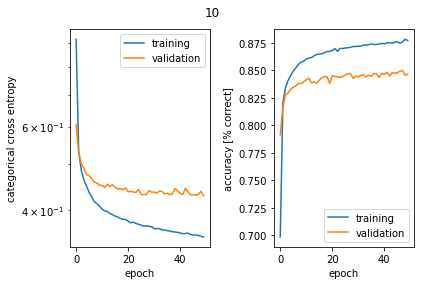

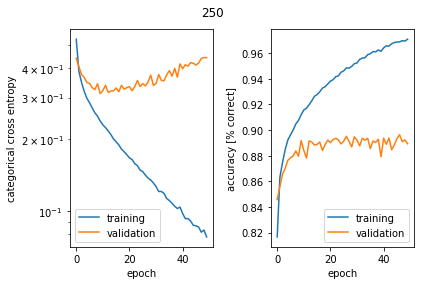

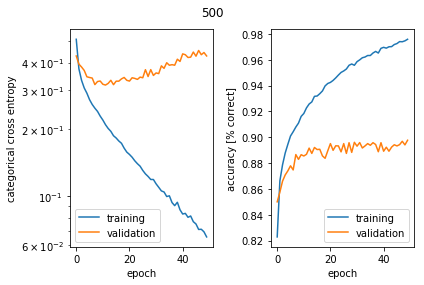

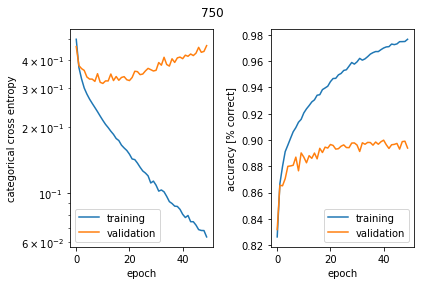

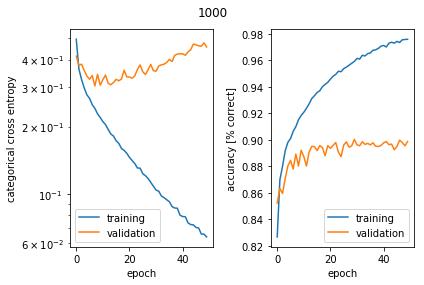

In [31]:
for history, lr in zip(fashion_mnist_histories, [10, 250, 500, 750, 1000]):
    plot_history(history, lr)

MNIST:

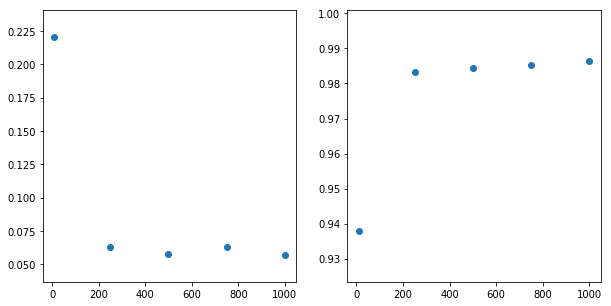

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter([10, 250, 500, 750, 1000], [min(history.history['val_loss']) for history in mnist_histories]);
plt.subplot(122)
plt.scatter([10, 250, 500, 750, 1000], [max(history.history['val_acc']) for history in mnist_histories]);

Fashion-MNIST:

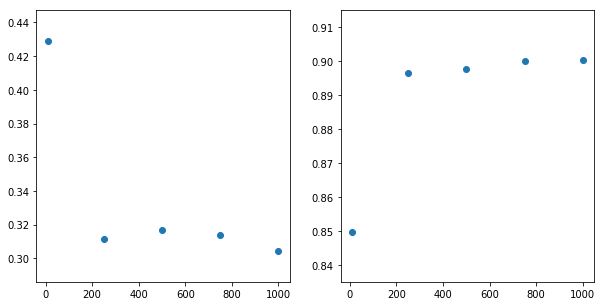

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter([10, 250, 500, 750, 1000], [min(history.history['val_loss']) for history in fashion_mnist_histories]);
plt.subplot(122)
plt.scatter([10, 250, 500, 750, 1000], [max(history.history['val_acc']) for history in fashion_mnist_histories]);

Answer to question 2:

We see that networks with 200 or more neurons start to converge to a function approximation that achieves 98.5% accuracy on MNIST and 90% accuracy on Fashion-MNIST, thus we believe that they are not able to approximate the real function such that the distance between the approximation and real function is any $\epsilon > 0$. Since the theorem doesn't touch upon the learnability of the appropriate parameters, we assume that in practice our learning approach fails to converge to these ideal parameters.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [127]:
# initialize list of lists 
data = [["-", "-", "-", "-", ".8859", ".33"],  
        ["yes", '-', "l2", ".1", ".8301", ".55"],
        ["yes", '-', "l2", ".01", ".8618", ".46"],
        ["yes", '-', "l2", ".001", ".8730", ".43"],
        ["yes", '-', "l2", ".0001", ".879", ".36"],
        ["no" , '-', 'l2', '.0001', '.891', '.36'],
        ["yes", '-', "l2", ".00001", ".8809", ".36"],
        
        ["yes", '-', "l1", ".1", ".7552", "1.72"],
        ["yes", '-', "l1", ".001", ".8557", "0.54"],
        
        ["yes", '0.1', "-", "-", ".8855", ".34"],
        ["yes", '0.2', "-", "-", ".8861", ".32"],
        ["no" , '0.2', "-", "-", ".8829", ".33"],
        ["yes", '0.3', "-", "-", ".88", ".33"],
        ["yes", '0.5', "-", "-", ".8855", ".37"],
        
        ["yes", '*0.1', "-", "-", ".8837", ".34"],
        ["yes", '*0.2', "-", "-", ".8871", ".34"],
        ["yes", '*0.5', "-", "-", ".8887", ".33"],
        
        
        ["yes", '*0.1', "l2", ".001", ".87", ".42"],
    
       ] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Batch Normalization', 'Dropout Parameter', 'Regularization Type', 'Regularization Parameter', 'Validation Score', 'Validation Loss' ]) 
  
# print dataframe. 
df

,Batch Normalization,Dropout Parameter,Regularization Type,Regularization Parameter,Validation Score,Validation Loss
0,-,-,-,-,.8859,.33
1,yes,-,l2,.1,.8301,.55
2,yes,-,l2,.01,.8618,.46
3,yes,-,l2,.001,.8730,.43
4,yes,-,l2,.0001,.879,.36
5,no,-,l2,.0001,.891,.36
6,yes,-,l2,.00001,.8809,.36
7,yes,-,l1,.1,.7552,1.72
8,yes,-,l1,.001,.8557,0.54
9,yes,0.1,-,-,.8855,.34


We decided to carry out the discussion with a table since networks were run in different computers simultaneously and the number of graphs created too much unrelated information on this notebook. 

We trained 17 different networks with a variety of parameter combinations as can be seen in the table. Network 0 indicates our naive network. Only a few of our regularized networks could improve on the best validation accuracy of the naive model, the network with 0.2 dropout applied to both hidden layers achieved a lower best validation loss and a higher accuracy. Network 5 achieved the best validation accuracy among our models but we observed it also overfits.
We choose network 10 as both validation metrics improved and it didn't overfit.

In [112]:
model = Sequential([
            Dense(50, input_shape=(784,)),
            Activation('relu'),
            Dense(50),
            Activation('relu'),
            Dense(10),
            Activation('softmax')
        ])

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

naive = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=100, validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.6036 - acc: 0.7947 - val_loss: 0.4814 - val_acc: 0.8270
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4162 - acc: 0.8525 - val_loss: 0.4279 - val_acc: 0.8472
Epoch 3/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.3758 - acc: 0.8659 - val_loss: 0.3911 - val_acc: 0.8593
Epoch 4/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3521 - acc: 0.8741 - val_loss: 0.3934 - val_acc: 0.8613
Epoch 5/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3362 - acc: 0.8787 - val_loss: 0.3763 - val_acc: 0.8660
Epoch 6/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.3228 - acc: 0.8832 - val_loss: 0.3853 - val_acc: 0.8621
Epoch 7/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.3126 - acc: 0.8863 - val_loss: 0.3781 - 

60000/60000 [==============================] - 1s 23us/step - loss: 0.1373 - acc: 0.9489 - val_loss: 0.4370 - val_acc: 0.8772
Epoch 60/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.1360 - acc: 0.9491 - val_loss: 0.4505 - val_acc: 0.8777
Epoch 61/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.1357 - acc: 0.9501 - val_loss: 0.4645 - val_acc: 0.8787
Epoch 62/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.1336 - acc: 0.9503 - val_loss: 0.4462 - val_acc: 0.8829
Epoch 63/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.1321 - acc: 0.9512 - val_loss: 0.4476 - val_acc: 0.8826
Epoch 64/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.1328 - acc: 0.9500 - val_loss: 0.4323 - val_acc: 0.8785
Epoch 65/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1266 - acc: 0.9530 - val_loss: 0.4462 - val_acc: 0.8805
Epoch 66/100
60000/60000 [==============

0.8859
0.3293101442217827


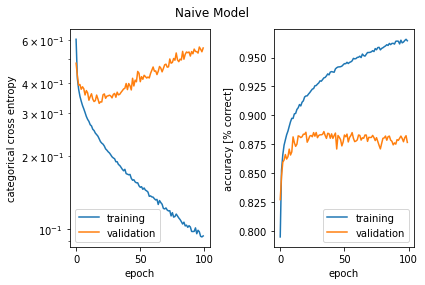

In [113]:
plot_history(naive, 'Naive Model');
print(max(naive.history['val_acc']))
print(min(naive.history['val_loss']))

In [114]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1, l2

model = Sequential([
            Dense(50, input_shape=(784,)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            Dense(50),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            Dense(10),
            BatchNormalization(),
            Activation('softmax')
        ])

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tuned = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=100, validation_data=(x_fashion_test, y_fashion_test), verbose=False)

0.8861
0.3278091260313988


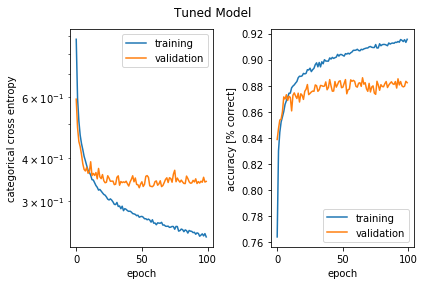

In [125]:
plot_history(tuned, 'Tuned Model');
print(max(tuned.history['val_acc']))
print(min(tuned.history['val_loss']))

Comparison:

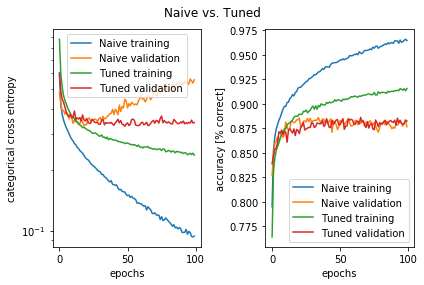

In [126]:
comparison_plot(naive, tuned, 'Naive', 'Tuned', 'Naive vs. Tuned');

Answer to question 2 (comments):

By applying regularization methods we successfully reduced overfitting, which can be observed by looking at the validation loss curves of the naive (going down and up) and tuned model (going down). This also resulted in a very minor validation accuracy increase (0.0002), even though they are still worse than the one layer model by a small margin.

Applying it to MNIST:

In [128]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1, l2

model = Sequential([
            Dense(50, input_shape=(784,)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            Dense(50),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            Dense(10),
            BatchNormalization(),
            Activation('softmax')
        ])

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mnist_2layer = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), verbose=False)

0.9771
0.07842011199356057


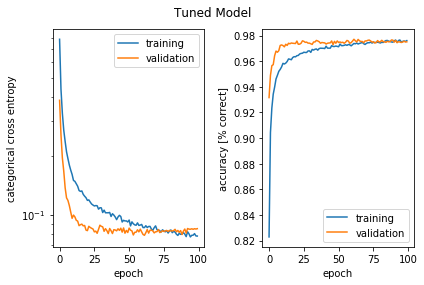

In [129]:
plot_history(mnist_2layer, 'Tuned Model');
print(max(mnist_2layer.history['val_acc']))
print(min(mnist_2layer.history['val_loss']))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [62]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_mnist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2611 - acc: 0.9186 - val_loss: 0.0555 - val_acc: 0.9825
Epoch 2/12
60000/60000 [==============================] - 82s 1ms/step - loss: 0.0804 - acc: 0.9758 - val_loss: 0.0390 - val_acc: 0.9869
Epoch 3/12
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0631 - acc: 0.9809 - val_loss: 0.0295 - val_acc: 0.9899
Epoch 4/12
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0528 - acc: 0.9843 - val_loss: 0.0295 - val_acc: 0.9903
Epoch 5/12
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0463 - acc: 0.9864 - val_loss: 0.0294 - val_acc: 0.9896
Epoch 6/12
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0415 - acc: 0.9874 - val_loss: 0.0342 - val_acc: 0.9892
Epoch 7/12
60000/60000 [==============================]

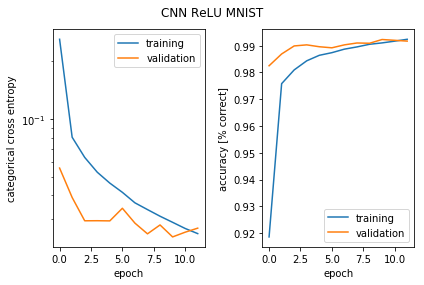

In [73]:
plot_history(cnn_mnist, 'CNN ReLU MNIST');

In [74]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_fashion_mnist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 90s 1ms/step - loss: 0.5786 - acc: 0.7972 - val_loss: 0.3667 - val_acc: 0.8718
Epoch 2/12
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3710 - acc: 0.8678 - val_loss: 0.3136 - val_acc: 0.8856
Epoch 3/12
60000/60000 [==============================] - 86s 1ms/step - loss: 0.3173 - acc: 0.8867 - val_loss: 0.2874 - val_acc: 0.8943
Epoch 4/12
60000/60000 [==============================] - 85s 1ms/step - loss: 0.2854 - acc: 0.8978 - val_loss: 0.2602 - val_acc: 0.9049
Epoch 5/12
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2590 - acc: 0.9059 - val_loss: 0.2529 - val_acc: 0.9051
Epoch 6/12
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2404 - acc: 0.9147 - val_loss: 0.2374 - val_acc: 0.9117
Epoch 7/12
60000/60000 [==============================]

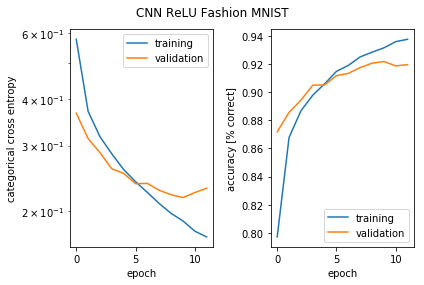

In [76]:
plot_history(cnn_fashion_mnist, 'CNN ReLU Fashion MNIST');

Answer to question 3:

For MNIST our best network with two dense layers so far had obtained a 98% accuracy on the validation set whereas the CNN achieved 99.23%; for Fashion-MNIST our best network with two dense layers so far had obtained a 89% accuracy on the validation set whereas the CNN achieved 92.17%. These are expected results since CNN is a good architecture for processing images.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [27]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_mnist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 168s 3ms/step - loss: 2.3124 - acc: 0.1097 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 2/12
60000/60000 [==============================] - 166s 3ms/step - loss: 2.3009 - acc: 0.1123 - val_loss: 2.2979 - val_acc: 0.1135
Epoch 3/12
60000/60000 [==============================] - 165s 3ms/step - loss: 0.8209 - acc: 0.7241 - val_loss: 0.2642 - val_acc: 0.9240
Epoch 4/12
60000/60000 [==============================] - 165s 3ms/step - loss: 0.3223 - acc: 0.9045 - val_loss: 0.2107 - val_acc: 0.9369
Epoch 5/12
60000/60000 [==============================] - 166s 3ms/step - loss: 0.2667 - acc: 0.9217 - val_loss: 0.1615 - val_acc: 0.9526
Epoch 6/12
60000/60000 [==============================] - 165s 3ms/step 

0.9704
0.09438880087733269


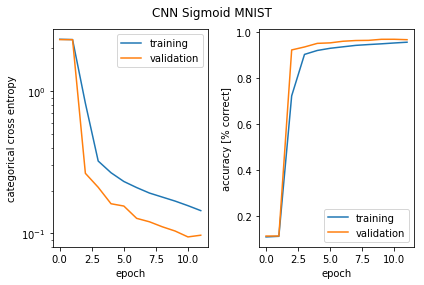

In [29]:
plot_history(cnn_mnist,"CNN Sigmoid MNIST");

print(max(cnn_mnist.history['val_acc']))
print(min(cnn_mnist.history['val_loss']))

In [67]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_batchnorm_mnist = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 176s 3ms/step - loss: 0.7500 - acc: 0.8441 - val_loss: 0.4033 - val_acc: 0.9159
Epoch 2/12
60000/60000 [==============================] - 175s 3ms/step - loss: 0.3296 - acc: 0.9434 - val_loss: 0.1562 - val_acc: 0.9761
Epoch 3/12
60000/60000 [==============================] - 169s 3ms/step - loss: 0.2164 - acc: 0.9578 - val_loss: 0.1298 - val_acc: 0.9723
Epoch 4/12
60000/60000 [==============================] - 168s 3ms/step - loss: 0.1617 - acc: 0.9652 - val_loss: 0.1020 - val_acc: 0.9749
Epoch 5/12
60000/60000 [==============================] - 173s 3ms/step - loss: 0.1329 - acc: 0.9693 - val_loss: 0.0735 - val_acc: 0.9811
Epoch 6/12
60000/60000 [==============================] - 172s 3ms/step - loss: 0.1131 - acc: 0.9727 - val_loss: 0.0573 - val_acc: 0.9853
Epoch 7/12
60000/60000 [=========================

0.9878
0.037282277616485955


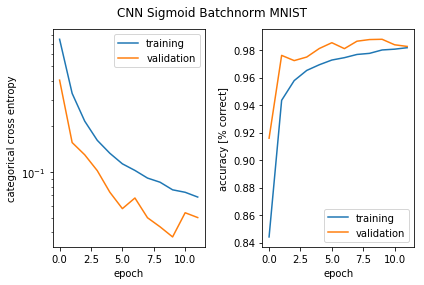

In [78]:
plot_history(cnn_batchnorm_mnist, 'CNN Sigmoid Batchnorm MNIST');

print(max(cnn_batchnorm_mnist.history['val_acc']))
print(min(cnn_batchnorm_mnist.history['val_loss']))

Answer to question 1:

The network with sigmoid activations perform worse than the ReLU network probably because the network suffers from saturating activations/vanishing gradients.

Answer to question 2:

Although it still couldn't reach the ReLU-CNN performance, adding batch normalization to this network improved its accuracy by helping fix the saturating activations/vanishing gradients problem.